In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, GRU
import seaborn as sns
import sklearn as sks
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:

client = Client('dmjW0ITi9h77eMWmpVtHZRlkJZW8Pe752YcHIWOoK87AWz8Z3gV19kZ8tTnfHHcr', 'CVKE78zOoQDDqYuovQiyOVZbtf2GlgKD4jqCl3LymVXFb93Sw7FYvitOjudyThbz', tld='us')

klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1HOUR, "1 Jan, 2017")

print(klines [:10])

df = pd.DataFrame(klines)

[[1569225600000, '209.55000000', '209.55000000', '209.55000000', '209.55000000', '0.01000000', 1569229037144, '2.09550000', 1, '0.00000000', '0.00000000', '0'], [1569243600000, '209.55000000', '209.55000000', '209.55000000', '209.55000000', '0.00000000', 1569247199999, '0.00000000', 0, '0.00000000', '0.00000000', '0'], [1569247200000, '209.55000000', '209.55000000', '209.55000000', '209.55000000', '0.00000000', 1569250799999, '0.00000000', 0, '0.00000000', '0.00000000', '0'], [1569250800000, '209.55000000', '209.55000000', '209.55000000', '209.55000000', '0.00000000', 1569254399999, '0.00000000', 0, '0.00000000', '0.00000000', '0'], [1569254400000, '209.55000000', '209.55000000', '209.55000000', '209.55000000', '0.00000000', 1569257999999, '0.00000000', 0, '0.00000000', '0.00000000', '0'], [1569258000000, '209.55000000', '209.55000000', '209.55000000', '209.55000000', '0.00000000', 1569261599999, '0.00000000', 0, '0.00000000', '0.00000000', '0'], [1569261600000, '209.55000000', '209.55

In [3]:

import requests
import pandas as pd

url = "https://api.alternative.me/fng/?limit=900&format=csv&date_format=us"

params = {
    "limit": 1400,
    "format": "json",
    "date_format": "us"
}

response = requests.get(url, params=params)
data = response.json()

df_data = []
for d in data["data"]:
    fng_value = d["value"]
    fng_classification = d["value_classification"]
    date = d["timestamp"]
    df_data.append([date, fng_value, fng_classification])

df2 = pd.DataFrame(df_data, columns=["Date", "FNG Value", "FNG Classification"])

In [4]:

df = df.apply(pd.to_numeric, errors='coerce')
df = df.astype(float)

In [5]:

df2['Date'] = pd.to_datetime(df2['Date'], format='%m-%d-%Y').dt.strftime('%Y-%m-%d')
df2 = df2.iloc[::-1]

ethdf = df
# Preprocess the data
ethdf.rename(columns={0:'open_time', 1:'open', 2:'high', 3:'low', 4:'close', 5:'volume', 6:'close_time', 7:'quote_asset_volume', 8:'number_of_trades', 9:'taker_buy_base_asset_volume', 10:'taker_buy_quote_asset_volume', 11:'ignore'}, inplace=True)
ethdf['date'] = pd.to_datetime(ethdf['open_time'], unit='ms')

ethdf.rename(columns = {'date':'datetime'}, inplace = True)
ehtdf = ethdf.sort_values(by='datetime')
del ethdf['open_time']

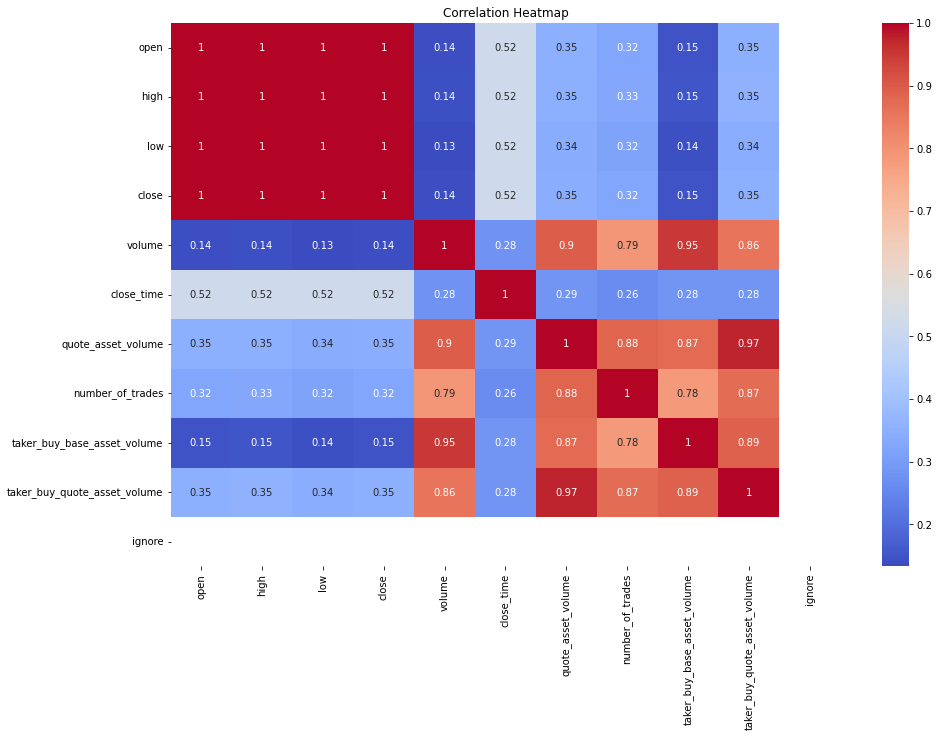

In [6]:
plt.figure(figsize = (15, 10))
# Create a correlation matrix from the DataFrame
corr_matrix = df.corr()

# Generate the heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

In [7]:
ethdf.isnull().sum()

open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ignore                          0
datetime                        0
dtype: int64

In [8]:

ethdf['Date'] = pd.to_datetime(ethdf['datetime']).dt.date


In [9]:

dataset = ethdf[[ 'datetime', 'Date', 'open','low','high','close']].copy()
# Target feature
y_target = 'Close'
dataset.head()

,datetime,Date,open,low,high,close
0,2019-09-23 08:00:00,2019-09-23,209.55,209.55,209.55,209.55
1,2019-09-23 13:00:00,2019-09-23,209.55,209.55,209.55,209.55
2,2019-09-23 14:00:00,2019-09-23,209.55,209.55,209.55,209.55
3,2019-09-23 15:00:00,2019-09-23,209.55,209.55,209.55,209.55
4,2019-09-23 16:00:00,2019-09-23,209.55,209.55,209.55,209.55


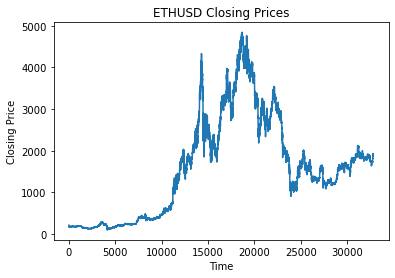

In [10]:
# Extract the closing prices from the DataFrame
closing_prices = dataset['close'].astype(float)  # Assuming the column name for closing price is 'close'

# Create a line plot
plt.plot(closing_prices)
plt.title("ETHUSD Closing Prices")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.show()

In [11]:

df2['Date'] = pd.to_datetime(df2['Date']).dt.date.astype(str)

In [12]:

dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date.astype(str)

In [13]:
df2.dtypes

Date                  object
FNG Value             object
FNG Classification    object
dtype: object

In [14]:

df_combined = pd.merge(dataset, df2, on='Date')


In [15]:
df_combined.head()

,datetime,Date,open,low,high,close,FNG Value,FNG Classification
0,2019-11-29 00:00:00,2019-11-29,150.57,150.24,152.85,152.34,31,Fear
1,2019-11-29 01:00:00,2019-11-29,152.66,151.68,152.80,152.17,31,Fear
2,2019-11-29 02:00:00,2019-11-29,152.03,151.72,152.25,152.01,31,Fear
3,2019-11-29 03:00:00,2019-11-29,152.01,152.00,152.87,152.45,31,Fear
4,2019-11-29 04:00:00,2019-11-29,152.48,151.92,152.61,152.17,31,Fear


In [16]:

df_combined = df_combined.drop(['FNG Classification', 'Date'], axis = 1)

In [17]:

df_combined["FNG"] = df_combined["FNG Value"]

In [18]:

df_combined = df_combined.drop(['FNG Value'], axis = 1)

In [19]:

df_combined = df_combined.set_index('datetime')

In [20]:
df_combined.head()

,open,low,high,close,FNG
datetime,,,,,
2019-11-29 00:00:00,150.57,150.24,152.85,152.34,31
2019-11-29 01:00:00,152.66,151.68,152.80,152.17,31
2019-11-29 02:00:00,152.03,151.72,152.25,152.01,31
2019-11-29 03:00:00,152.01,152.00,152.87,152.45,31
2019-11-29 04:00:00,152.48,151.92,152.61,152.17,31


In [21]:

df_combined = pd.concat([
    df_combined.iloc[:,0],
    df_combined.iloc[:, 1:len(df_combined.columns)].astype('float')
], axis = 1)
df_combined.dtypes

open     float64
low      float64
high     float64
close    float64
FNG      float64
dtype: object

<AxesSubplot:>

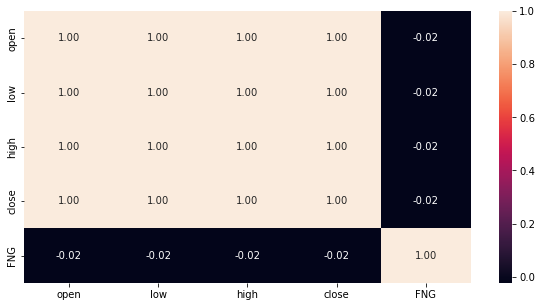

In [22]:
plt.figure(figsize = (10, 5))
sns.heatmap(
    df_combined.corr(), annot = True, fmt = ".2f"
)

In [23]:
n_time_steps = 24
windows = []
target = []

data = df_combined[['low', 'high', 'open', 'close']]  # Include all relevant columns
for i in range(len(data) - n_time_steps):
    x = data.iloc[i:i+n_time_steps]
    y = data.iloc[i+n_time_steps]
    windows.append(x)
    target.append(y)

# Convert to numpy arrays
windows = np.array(windows)
target = np.array(target)
print("Length of windows:", len(windows))

Length of windows: 31200


In [24]:

sc = StandardScaler()
n_samples, n_time_steps, n_features = windows.shape
windows_2d = windows.reshape(n_samples, n_time_steps * n_features)

windows_scaled = sc.fit_transform(windows_2d)
target_scaled = sc.fit_transform(target)

In [85]:
print(windows_scaled.shape)

(31200, 96)


In [86]:

num_train = int(0.80 * windows_scaled.shape[0])

X_train = windows_scaled[:num_train].reshape(num_train, n_time_steps, n_features)
X_test = windows_scaled[num_train:].reshape(windows_scaled.shape[0] - num_train, n_time_steps, n_features)
y_train = target_scaled[:num_train].reshape(num_train, n_features)
y_test = target_scaled[num_train:].reshape(target_scaled.shape[0] - num_train, n_features)



In [102]:
from tensorflow.keras.optimizers import Adam

epochs = 30
batch_size = 128
loss = 'mse'
dropout = 0.2
activ_func = 'relu'
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [103]:
# from tensorflow.keras.layers import Bidirectional, LSTM
# def build_bidirectional_lstm_model(input_data, output_size, activ_func, dropout, loss, optimizer):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(256, activation="tanh", input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True)))
#     model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, activation="tanh", dropout= 0.2, return_sequences=True)))
#     model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(64, activation="tanh", return_sequences=False)))
#     model.add(Dense(units=output_size, activation='tanh'))
#     model.compile(loss=loss, optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#     return model

# def build_lstm_model(input_data, output_size, activ_func, dropout, loss, optimizer):
#     model = Sequential()
#     model.add(GRU(units=256, activation="tanh", input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True))
#     model.add(GRU(units=256, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True, dropout=0.3))
#     model.add(GRU(units=128, return_sequences=True, dropout=0.3))
#     model.add(GRU(units=128, return_sequences=True))
#     model.add(GRU(units=64, return_sequences=True, dropout=0.2))
#     model.add(GRU(units=32, return_sequences=False))
#     model.add(Dense(units=output_size))
#     model.add(Activation(activ_func))
#     model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#     return model
from tensorflow.keras.layers import Bidirectional, LSTM
def build_lstm_model(input_data, output_size, activ_func, dropout, loss, optimizer):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation="tanh", input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(64, activation="tanh", return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_data.shape[2], activation='linear'))
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model


In [104]:
X_train.shape

(24960, 24, 4)

In [105]:

# model = build_bidirectional_lstm_model(X_train, output_size=n_features, activ_func=activ_func,
#                                                   dropout=dropout, loss=loss, optimizer= optimizer)
model = build_lstm_model(X_train, output_size=n_features, activ_func=activ_func, dropout=dropout, loss=loss, optimizer=optimizer)

out = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=False, validation_split=0.2)

Epoch 1/30
156/156 [==============================] - 31s 159ms/step - loss: 0.2146 - rmse: 0.4633 - val_loss: 0.0108 - val_rmse: 0.1038
Epoch 2/30
156/156 [==============================] - 24s 157ms/step - loss: 0.0525 - rmse: 0.2291 - val_loss: 0.0062 - val_rmse: 0.0785
Epoch 3/30
156/156 [==============================] - 26s 167ms/step - loss: 0.0392 - rmse: 0.1980 - val_loss: 0.0037 - val_rmse: 0.0612
Epoch 4/30
156/156 [==============================] - 25s 163ms/step - loss: 0.0314 - rmse: 0.1771 - val_loss: 0.0032 - val_rmse: 0.0563
Epoch 5/30
156/156 [==============================] - 25s 161ms/step - loss: 0.0272 - rmse: 0.1649 - val_loss: 0.0031 - val_rmse: 0.0560
Epoch 6/30
156/156 [==============================] - 25s 162ms/step - loss: 0.0243 - rmse: 0.1560 - val_loss: 0.0032 - val_rmse: 0.0568
Epoch 7/30
156/156 [==============================] - 25s 162ms/step - loss: 0.0224 - rmse: 0.1498 - val_loss: 0.0034 - val_rmse: 0.0580
Epoch 8/30
156/156 [=====================

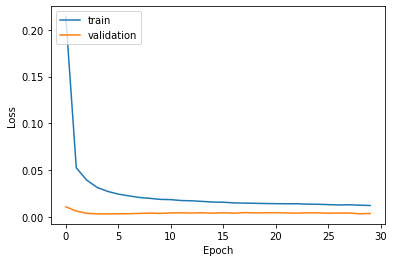

In [106]:
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [92]:
pred = model.predict(X_test)
pred_transformed = sc.inverse_transform(pred)
y_test_transformed = sc.inverse_transform(y_test)

195/195 [==============================] - 2s 5ms/step


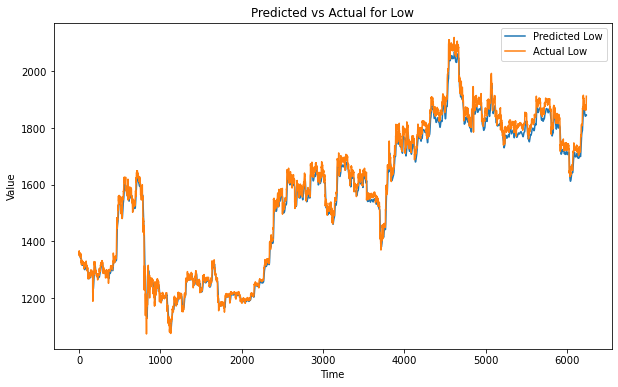

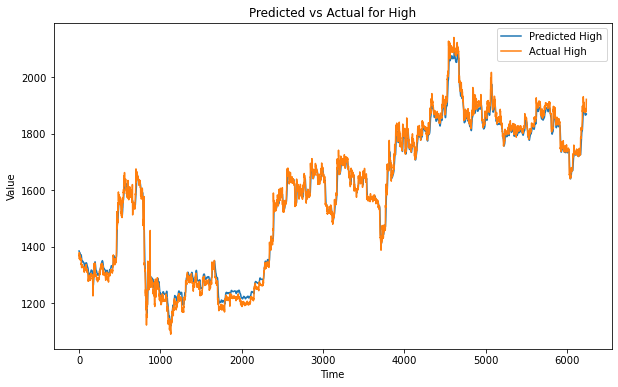

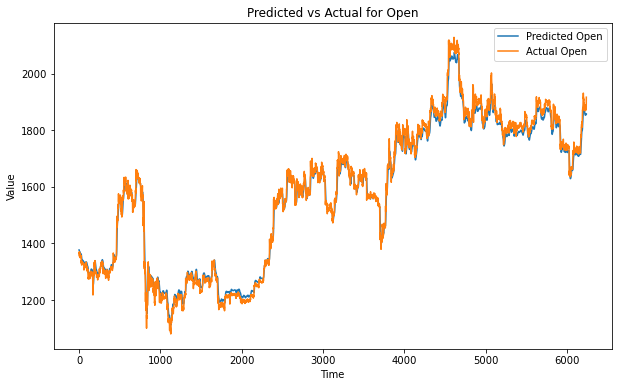

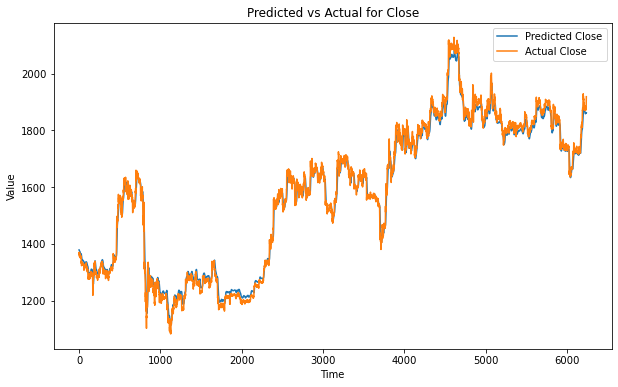

In [93]:
num_features = pred_transformed.shape[1]
feature_labels = ['Low', 'High', 'Open', 'Close']  # Replace with actual feature labels

for i in range(num_features):
    plt.figure(figsize=(10, 6))
    plt.plot(pred_transformed[:, i], label=f'Predicted {feature_labels[i]}')
    plt.plot(y_test_transformed[:, i], label=f'Actual {feature_labels[i]}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Predicted vs Actual for {feature_labels[i]}')
    plt.legend()
    plt.show()

In [94]:
model.save('1hour_close_FNG.h5')

In [95]:
import joblib

joblib.dump(sc, 'scaler1hour.pkl')

['scaler1hour.pkl']